# 2D GradCam & 2D Occlusion  
In this notebook we are going to see how the Gradcam and an Occlusion Algorithm works.
We won't train a model by ourself but rather use the power of freely available models which are pretrained by others on a large set of images (Imagenet
 14'197'122 images ). This notebook consist of the following steps:


1.   Download & set the weights to a given modelarchitecture
2.   Predict the class of an image with the model (likelihoods)
3.   xAI, inspect which region of the image had the highest impact on the prediction with:
  - GradCAM
  - Occlusion

Imagenet: https://www.image-net.org/about.php

GradCam: https://arxiv.org/pdf/1710.11063v2.pdf

This notebook is adapted from https://keras.io/examples/vision/grad_cam/.

-------

For the algorithms to work, we need some helper functions, if you are curious try to understand what they do, otherwise you can safely execute and  **ignore the  cell below**.

In [1]:
# @title imports & helperfunctions

# Tensor Manipulation
import numpy as np
import os
os.environ["KERAS_BACKEND"] ="tensorflow"
import keras
import tensorflow as tf

print(f'Keras_version: {keras.__version__}')# 3.5.0
print(f'torch_version: {tf.__version__}')# 2.5.1+cu121
print(f'keras backend: {keras.backend.backend()}')

from skimage.transform import resize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Display
from IPython.display import Image
from IPython.display import display as img_display
import matplotlib.cm as cm
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import ipywidgets as widgets
from tabulate import tabulate

#IO
#from google.colab import files
import os
import requests
import ast


def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (size, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, size, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model_2d, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model_2d.inputs], [model_2d.get_layer(last_conv_layer_name).output, model_2d.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    # resize the heatmap to be the same size as the original image
    heatmap = heatmap.numpy()
    heatmap = resize(heatmap, img_array.shape[1:3])
    heatmap = (tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)).numpy()

    return heatmap


def iter_occlusion(volume, size=4, stride = None):
    # volume: np array in shape 128, 128, 64, 1

    occlusion_center = np.full((size, size, 3), [0], np.float32)

    for y in range(0, volume.shape[0]-size+1, stride):
        for x in range(0, volume.shape[1]-size+1, stride):
            tmp = volume.copy()

            tmp[y:y + size, x:x + size, :] = occlusion_center

            yield x, y, tmp


def rgb_image_occlusion(volume, model_2d, correct_class, occlusion_size, occlusion_stride=None,
                       clip_pred_hm=True):

    print('occluding...')
    if occlusion_stride is None:
        stride = occlusion_size
    elif occlusion_stride > occlusion_size:
        raise ValueError('stride must be smaller or equal size')

    if occlusion_stride == occlusion_size:
        if (not (volume.shape[0] / occlusion_size).is_integer() or
                not (volume.shape[1] / occlusion_size).is_integer()):

            raise ValueError('size does not work with this volume')
    elif occlusion_stride != occlusion_size:
        if (((volume.shape[0] - occlusion_size) % occlusion_stride) != 0 or
                ((volume.shape[1] - occlusion_size) % occlusion_stride) != 0):

            raise ValueError('shape and size do not match')
    heatmap_prob_sum = np.zeros((volume.shape[0], volume.shape[1]), np.float32)
    heatmap_occ_n = np.zeros((volume.shape[0], volume.shape[1]), np.float32)
    total_steps = int(np.prod(((np.array(volume.shape[0:2]) - occlusion_size) / occlusion_stride) + 1))
    with tqdm(total=total_steps, desc="Calculating heatmap") as pbar:
        for n, (x, y, vol_float) in enumerate(iter_occlusion(volume, size=occlusion_size, stride=occlusion_stride)):
            X = vol_float.reshape(1, volume.shape[0], volume.shape[1], volume.shape[2])
            out = model_2d.predict(X, verbose=0)

            heatmap_prob_sum[y:y + occlusion_size, x:x + occlusion_size] += out[0, correct_class]
            heatmap_occ_n[y:y + occlusion_size, x:x + occlusion_size] += 1
            pbar.update(1)
    print("calculating heatmap...")
    heatmap = heatmap_prob_sum / heatmap_occ_n
    if clip_pred_hm:
        cut_off = model_2d.predict(volume.reshape(1, volume.shape[0], volume.shape[1], volume.shape[2]), verbose=0)[0,
                                 correct_class]
        heatmap = np.abs(np.minimum(heatmap - cut_off, 0))
    return heatmap  # , class_pixels


def generate_all_images(img_array, heatmap, modprob):
    f, axs = plt.subplots(1, 3, figsize=(24,8))
    (ax1, ax2, ax3) = axs

    ax1.imshow(img_array[0]/255, vmin = 0, vmax = 1)
    ax2.imshow(img_array[0]/255, vmin = 0, vmax = 1)
    ax2.imshow(heatmap, cmap='jet', vmin = np.min(heatmap), vmax = np.max(heatmap), alpha=0.4)
    im = ax3.imshow(heatmap, cmap='jet', vmin = np.min(heatmap), vmax = np.max(heatmap), alpha=0.4)
    cb = f.colorbar(im, ax=axs.ravel().tolist())
    cb.ax.axhline(y=modprob, linewidth = 3, c='black')


def generate_superimposed_image(img_array, heatmap, save_name = None):
    f, axs = plt.subplots(1, 1, figsize=(5,5))
    (ax1) = axs

    ax1.imshow(img_array[0]/255, vmin = 0, vmax = 1)
    ax1.imshow(heatmap, cmap='jet', vmin = np.min(heatmap), vmax = np.max(heatmap), alpha=0.4)

    plt.axis('off')

    axins = inset_axes(
            ax1,
            width="5%",  # width: 5% of parent_bbox width
            height="100%",  # height: 50%
            loc="lower left",
            bbox_to_anchor=(1.01, 0., 1, 1),
            bbox_transform=ax1.transAxes,
            borderpad=0,
        )
    plt.colorbar(
            matplotlib.cm.ScalarMappable(
                norm=matplotlib.colors.Normalize(vmin=heatmap.min(), vmax=heatmap.max(), clip=False),
                cmap="jet"),
            cax=axins,
            label='',
            ticks=np.trunc(np.linspace(heatmap.min(), heatmap.max(), 5)*100)/100)

    if save_name is not None:
        plt.savefig(save_name, bbox_inches='tight', dpi=300)


def upload_image_colab(filename):
    uploaded = files.upload()
    for uploaded_filename in uploaded.keys():
        os.rename(uploaded_filename, filename)
        display(Image(filename))


def set_model_globals(model_name):
    global model, img_size, preprocess_input, decode_predictions
    if model_name == 'VGG16':
        model_builder = keras.applications.vgg16.VGG16
        img_size = (224, 224)
        preprocess_input = keras.applications.vgg16.preprocess_input
        decode_predictions = keras.applications.vgg16.decode_predictions
    elif model_name == 'ResNet50V2':
        model_builder = keras.applications.resnet_v2.ResNet50V2
        img_size = (224, 224)
        preprocess_input = keras.applications.resnet_v2.preprocess_input
        decode_predictions = keras.applications.resnet_v2.decode_predictions
    elif model_name == 'Xception':
        model_builder = keras.applications.xception.Xception
        img_size = (299, 299)
        preprocess_input = keras.applications.xception.preprocess_input
        decode_predictions = keras.applications.xception.decode_predictions
    else:
        print("Invalid model selected")
        return
    model = model_builder(weights="imagenet")

#widgets
model_dropdown = widgets.Dropdown(
    options=['VGG16', 'ResNet50V2', 'Xception'],
    description='Model:',
)
ok_button = widgets.Button(description="OK")


def on_ok_button_clicked(b):
    set_model_globals(model_dropdown.value)
    if model is not None:
        print(f"Selected Model: {model_dropdown.value}")
        print(f"Image size: {img_size}")
        model.summary()
    else:
        print("No model selected or an error occurred.")

#button link
ok_button.on_click(on_ok_button_clicked)

def load_labels(verbose=0):
  url = 'https://raw.githubusercontent.com/tensorchiefs/dl_course_2024/main/notebooks/imagenet_labels.txt'
  response = requests.get(url)
  if response.status_code == 200:
      content = response.text
      try:
          # Use ast.literal_eval to safely parse the dictionary string
          imagenet_classes = ast.literal_eval(content)
          print("Dictionary loaded successfully!")
          if verbose ==1:
            for key in list(imagenet_classes.keys())[:5]:
                print(f"{key}: {imagenet_classes[key]}")
      except ValueError as e:
          print(f"Error parsing the content: {e}")
  display_options = [f"{index}: {name}" for index, name in imagenet_classes.items()]
  return display_options

display_options = load_labels(verbose=0)
class_dropdown = widgets.Dropdown(options=display_options,description='ImageNet Class:',)

# patch predictions
def patch_predict_image(x_range, y_range):
    x1, x2 = x_range
    y1, y2 = y_range
    img_array_patched = img_array.copy()
    img_array_patched[:,y1:y2,x1:x2,:]=0
    img_normalized = ((img_array_patched - img_array_patched.min()) / (img_array_patched.max() - img_array_patched.min()) * 255).astype(np.uint8).squeeze()
    plt.imshow(img_normalized, vmin=0, vmax=255),plt.show();

    preds = model.predict(img_array_patched, verbose=0)
    top_5_preds = decode_predictions(preds, top=5)[0]
    data = []
    for pred in top_5_preds:
        data.append([pred[1], pred[2]])
    print(tabulate(data, headers=["Class", "P(y|x)"], tablefmt="pipe"))

# occlusion stride

def calculate_occ_stride(quadratic_size=224):
  occ_pairs=[]
  for occ_size in range(1,quadratic_size):
    for occ_stride in range(1,quadratic_size):
      if occ_stride >= occ_size:
        continue
      if (quadratic_size -occ_size)%occ_stride ==0:
        occ_pairs.append((occ_size,occ_stride))
  occ_pairs=[f'occlusion: {item[0]}, stride: {item[1]}'for item in occ_pairs ]
  return occ_pairs

Keras_version: 3.5.0
torch_version: 2.17.1
keras backend: tensorflow
Dictionary loaded successfully!


#Model selection & Weight loading

Excute the cell below, choose a given architecture and press "OK" to load

 (it might take some seconds to load , to change to another model -> excecute the cell again):


The weights of the models trained on imagenet are automatically loaded:

- Xception: https://arxiv.org/abs/1610.02357
- Resnet :  https://arxiv.org/abs/1512.03385
- VGG16:    https://arxiv.org/abs/1409.1556v6

Check out the size of the models how many parameters are used?


In [2]:
display(model_dropdown, ok_button)

Dropdown(description='Model:', options=('VGG16', 'ResNet50V2', 'Xception'), value='VGG16')

Button(description='OK', style=ButtonStyle())

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Selected Model: VGG16
Image size: (224, 224)
Model: "vgg16"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0

## Imagenet classes
The loaded models are pretrained on imagenet with 1000 classes, with the dropdown menu below you can browse through the classes and find the according index e.g. 386 : "African elephant"


In [3]:
display(class_dropdown) # has no effect, only for browsing

Dropdown(description='ImageNet Class:', options=('0: tench, Tinca tinca', '1: goldfish, Carassius auratus', '2…

## Image
Lets choose an "African Elephant" image from the internet

Original link:"https://upload.wikimedia.org/wikipedia/commons/3/37/African_Bush_Elephant.jpg"

In [4]:
img_path = keras.utils.get_file("african_elephant.jpg","https://raw.githubusercontent.com/tensorchiefs/dl_course_2024/main/notebooks/African_Bush_Elephant.jpg")
img_display(Image(img_path,width=300))

Output hidden; open in https://colab.research.google.com to view.

## Forward pass
the original image gets preprocessed & passed to the model , display the top 5 predictions

In [5]:
img_array_orig = get_img_array(img_path, size=img_size)
img_array = preprocess_input(img_array_orig.copy())
preds = model.predict(img_array, verbose=0)
top_5_preds = decode_predictions(preds, top=5)[0]
data = []
for pred in top_5_preds:
    data.append([pred[1], pred[2]])
print(tabulate(data, headers=["Class", "P(y|x)"], tablefmt="pipe"))

35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
| Class            |      P(y|x) |
|:-----------------|------------:|
| African_elephant | 0.851814    |
| tusker           | 0.139883    |
| Indian_elephant  | 0.00822864  |
| triceratops      | 6.96552e-05 |
| warthog          | 1.86623e-06 |


The model predicts the class correctly. Do the other classes in the top 5 also make sense?:
- (101 tusker)
- (385 indian elephant)


# xAI

Lets inspect the regions of the image which lead the model to assign a high likelihood for the image to belong to the class African Elephant.



# GradCam

The Grad-CAM (Gradient-weighted Class Activation Mapping) algorithm helps us understand how neural networks "think" by visualizing which image regions influence their decisions.  The gradients for the selected class ("African Elephant") to each activation map in the last convolutional layer are calculated.The average gradient per activation map serves as weight to score the "importance of the map". A weighted sum of these Activation maps, results in a final heatmap, which provides insight of the region that influenced the prediciton the most.


In [9]:
prediction_index=386 # african elephant

name of the last layer: block5_conv3
Activation map size and number of maps: (None, 14, 14, 512)
/root/.keras/datasets/superimposed_african_elephant.jpg


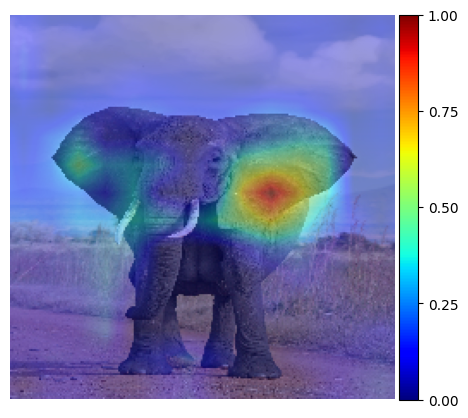

In [8]:
# get last convolutional layer & size
last_conv_layer_name = [vis_layer for vis_layer in [i.name for i in model.layers] if "conv" in vis_layer][-1]
print(f'name of the last layer: {last_conv_layer_name}')
print(f'Activation map size and number of maps: {model.get_layer(last_conv_layer_name).output.shape}')

# Generate class activation heatmap
heatmap_gradcam = make_gradcam_heatmap(img_array, model, last_conv_layer_name,pred_index=prediction_index)

# generate superimposed image
superimposed_img_path=os.path.join(os.path.split(img_path)[0],"superimposed_"+os.path.split(img_path)[1])
print(superimposed_img_path)
generate_superimposed_image(img_array_orig, heatmap_gradcam, save_name = superimposed_img_path )

# Occlusion by hand

Another way of inspecting which regions of  the image contribute to the likelihood of an instance belonging to a class, is to occlude a part of the image.

## 🔧 **YOUR TASK:**
Move the sliders below to occlude a part of the input image and see how the predictions change.

-  Can you find a spot which is marginally influencing the prediction?
-  or a spot where the likelihood is getting even higher for elephant??
-  what happens if create a large vertical patch ?


💡**Hint**:If you've chosen the vgg model don't worry if the colors looks a bit strange. The color channels of the image are bgr instead of rgb, since the creators of VGG trained it in this way

In [10]:
x_slider = widgets.IntRangeSlider(value=[100, 180],min=0,max=img_array.shape[1]-1,step=1,description='X Range:',continuous_update=False)
y_slider = widgets.IntRangeSlider(value=[100, 180],min=0,max=img_array.shape[1]-1,step=1,description='Y Range:',continuous_update=False)
widgets.interact(patch_predict_image, x_range=x_slider, y_range=y_slider);

interactive(children=(IntRangeSlider(value=(100, 180), continuous_update=False, description='X Range:', max=22…




<details>
  <summary>🔑 Click here to View Answers:</summary>

**For VGG (other models might differ)**

- if a small patch in the topleft corner (amongst many others) is occluded there is almost no influence on the prediciton

- Cover the upper 5th of the image or the lower 3rd and see that the likelihood for elephant increases. If all the other classes get more and more unlikely the more likely there is an elephant , if the important regions for elephant are not occluded.

- if you make a large enough standing up rectangle the image gets classified as a megalith , which is quite reasonable


</details>

## Occlusion Algorithm

now we can do it systematically, by defining a patch size and a stride to generate a set of occluded images.

In [11]:
if img_size[0]==224:
  occ_size = 26
  occ_stride = 18
if img_size[0]==299:
  occ_size = 35
  occ_stride = 22

print("number of occlusions: ", int(np.prod(((np.array(img_array.shape[1:3]) - occ_size) / occ_stride) + 1)))
print((np.asarray(img_array[0,:,:,0].shape) - occ_size) % occ_stride)

number of occlusions:  144
[0 0]


if you want to change the occlusion, use pairs from the dropdownmenu *below* and change the values for the according imagesize in the cell *above*:
```
occ_size = ...
occ_stride = ...
```

In [12]:
# @title valid occlusion and stride pairs { form-width: "10px" }
occ_stride_pairs=calculate_occ_stride(quadratic_size=img_size[0])
occ_stride_dropdown = widgets.Dropdown(options=occ_stride_pairs,description=f'pairs: {img_size[0]}')
display(occ_stride_dropdown) # Dropwdown has no effect , just browse valid occlusion and stride pairs

Dropdown(description='pairs: 224', options=('occlusion: 2, stride: 1', 'occlusion: 3, stride: 1', 'occlusion: …



For each of the occluded images, the prediction for the chosen class is now stored as a value for the occluded patch, for overlapping patches an average is calculated.
As seen before, some patches even make the probability for the chosen class larger, therefore we just consider the patches which result in lower predictionscores than the prediction without occlusion.

**execute the cell below**! Depending on how many occlusions are used, this calculation takes some time.

While this is calculating try to think of what a human would look at to identify an african elephant, would you still be able to classify correctly if parts of the image are occluded?

occluding...


Calculating heatmap: 100%|██████████| 144/144 [00:12<00:00, 11.94it/s]


calculating heatmap...
/root/.keras/datasets/occlusion_african_elephant.jpg


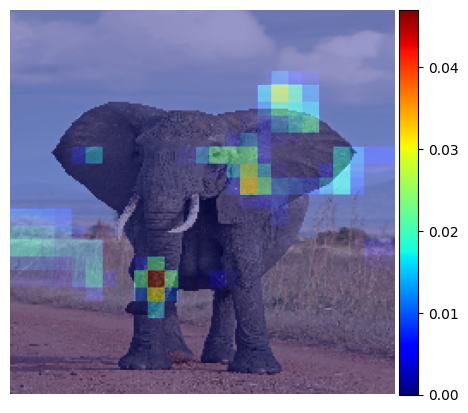

In [15]:
prediction_index=386 # african elephant

# generate occlusion class activation map
heatmap_occlusion =  rgb_image_occlusion(
    img_array[0], model_2d=model, correct_class = prediction_index,
    occlusion_size = occ_size, occlusion_stride = occ_stride
    )
# generate superimposed image
occluded_img_path=os.path.join(os.path.split(img_path)[0],"occlusion_"+os.path.split(img_path)[1])
print(occluded_img_path)
generate_superimposed_image(img_array_orig, heatmap_occlusion, save_name =occluded_img_path )

The resulting heatmap displays the deviation from the prediction without occlusion.

## 🔧 **YOUR TASK:**

* Look up the activation heatmap for 'car mirror',"475" ( or any other class which is not in the image), does it make sense?
* What happens if instead of a picture of a real elephant you use a picture of an elephant drawing, a plush or a model elephant. Does the activation heatmap still make any sense? (e.g. https://dinosours.files.wordpress.com/2015/09/img_4952.jpg)
* Try to use the algorithm for a picture of your choice (upload or search internet)
* What happens if you change the visualized layer (last_con_layer_name)?
* What happens if two objects of the same class are in one image?
* Try to use the algorithm for another Convolutional Neural Network (e.g. ResNet)


#### 💡 Hints

If this notebook is opened in colab  your can upload you image with the function:

```
img_path='YOUR_FILENAME.jpg'
upload_image_with_filename(img_path)
```

if you  are on a local instance just specify img_path

```
img_path= "/path/to/your/image/YOUR_FILENAME.jpg"
```

To get an image from the web just change the url:


```
img_path = keras.utils.get_file(
    "YOUR_FILENAME.jpg",
    "https://storage.googleapis.com/petbacker/images/blog/2017/dog-and-cat-cover.jpg",
    )
```



❗ upload own images HERE

In [ ]:
img_path='YOUR_FILENAME.jpg'
upload_image_colab(img_path)